In [64]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Photo Class**

In [65]:
import numpy as np
import cv2
import copy

class Photo:
  def __init__(self, photo, seg_map, name="NoName"):
    self.original = photo
    self.seg_map = seg_map
    self.height, self.width, self.channel = photo.shape
    self.name = name
  

  def add_padding(self, final_height, final_width):
    self.pad_left = (final_width - self.width)//2
    self.pad_right = final_width - self.width - self.pad_left
    self.pad_top = (final_height - self.height)//2
    self.pad_bottom = final_height - self.height - self.pad_top
    
    self.padded = cv2.copyMakeBorder(self.original,
                                    self.pad_top,self.pad_bottom,self.pad_left,self.pad_right,
                                    cv2.BORDER_CONSTANT,value=[0,0,0])
    
    self.seg_map = self.seg_map.astype('float32')
    self.padded_seg_map = cv2.copyMakeBorder(self.seg_map,
                                             self.pad_top,self.pad_bottom,self.pad_left,self.pad_right,
                                             cv2.BORDER_CONSTANT,value=[0])
    
    self.padded_height = final_height
    self.padded_width = final_width


  def largest_eigvec(self):
    #create 2 x N array
    Y, X = self.seg_map.nonzero() # (row# = Y) (col# = X)
    coords = np.zeros((2, len(X)))
    coords[0, :] = np.array(X)
    coords[1, :] = np.array(Y)
    avg = np.mean(coords, axis=1)
    coords = coords - avg.reshape(2, 1) #make it 0-mean

    u, s, vh = np.linalg.svd(coords, full_matrices=False)
    largest = np.argmax(s) #index of largest eigval
    self.eigvec = u[largest, :] #largest eigval for covarianace matrix (row of U)

    if self.eigvec[0] < 0: #also in largest_eigvec function, but for atomicity/redundancy
      self.eigvec *= -1

    return self.eigvec
  

  def _get_rotation_mat(self, alternative = False):
    #two different rotation is possible since we are matching a line to a line
    #use alternative= True/False to get both orientation matchings
    eigvec = self.largest_eigvec()
    if eigvec[0] < 0: #also in largest_eigvec function, but for atomicity/ redundancy
      eigvec *= -1
    if alternative:
      eigvec = -1*eigvec
    ax_vec = np.array([1,0])
    theta = np.arccos(np.dot(eigvec, ax_vec))
    direction = np.sign(eigvec[1])
    if alternative:
      self.angle_alt = direction*theta*180/np.pi
      return cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), self.angle_alt, 1)
    else:
      self.angle = direction*theta*180/np.pi
      return cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), self.angle, 1)
  

  def _rotate_seg_map(self, seg_map, transform_m, is_homography=False):
    tmp_seg = copy.deepcopy(seg_map).astype('float32')
    if is_homography:
      tmp_seg = cv2.warpPerspective(tmp_seg, transform_m, (self.padded_width, self.padded_height))
    else:
      tmp_seg = cv2.warpAffine(tmp_seg, transform_m, (self.padded_width, self.padded_height))
    return tmp_seg


  def align_eigvec(self, alternative = False):
    rotation_M = self._get_rotation_mat(alternative)
    if alternative:
      self.oriented_alt = cv2.warpAffine(self.padded, rotation_M, (self.padded_width, self.padded_height))
      self.seg_oriented_alt = self._rotate_seg_map(self.padded_seg_map, rotation_M)
    else:
      self.oriented = cv2.warpAffine(self.padded, rotation_M, (self.padded_width, self.padded_height))
      self.seg_oriented = self._rotate_seg_map(self.padded_seg_map, rotation_M)
  

  def _find_bbox(self, alternative = False):
    Y, X = None, None
    if alternative:
      Y, X = self.seg_oriented_alt.nonzero()
    else:
      Y, X = self.seg_oriented.nonzero()
    leftmost = np.min(X)
    rightmost = np.max(X)
    topmost = np.max(Y)
    bottommost = np.min(Y)
    return topmost, bottommost, leftmost, rightmost


  def contour_slices(self, alternative = False, num_slices = 10):
    tmp_seg = None
    if alternative:
      seg_map = self.seg_oriented_alt
    else:
      seg_map = self.seg_oriented
    
    topmost, bottommost, leftmost, rightmost = self._find_bbox(alternative)

    #use empty array instead of fixed size so that slices with no intersection can be left out
    X = [] 
    Y = []
    h_interval = (rightmost-leftmost)/(num_slices+1) #double
    for i in range(num_slices):
      slice_pos = int(leftmost + h_interval*(i+1)) #integer value
      y_vals = seg_map[:, slice_pos].nonzero()[0]
      if y_vals.size == 0:
        continue
      X.append(slice_pos)
      Y.append(np.min(y_vals)) #lowest contour intersection
      X.append(slice_pos)
      Y.append(np.max(y_vals)) #highest contour intersection
    
    #fewer slices since sneakers are more wide than tall
    num_slices //= 2
    v_interval = (topmost-bottommost)/(num_slices+1) #double
    X_h = np.zeros(num_slices*2)
    Y_h = np.zeros(num_slices*2)
    for i in range(num_slices):
      slice_pos = int(bottommost + v_interval*(i+1)) #integer value
      x_vals = seg_map[slice_pos, :].nonzero()[0]
      if x_vals.size == 0:
        continue
      Y.append(slice_pos)
      X.append(np.min(x_vals)) #leftmost contour intersection
      Y.append(slice_pos)
      X.append(np.max(x_vals)) #rightmost contour intersection

    X = np.array(X)
    Y = np.array(Y)

    if alternative:
      self.X_alt, self.Y_alt = X,Y
    else:
      self.X, self.Y = X,Y

    return X, Y
  

  def homography_transform(self, homography_m):
    self.transformed = cv2.warpPerspective(self.oriented, homography_m, (self.padded_width, self.padded_height))
    self.seg_transformed = self._rotate_seg_map(self.seg_oriented, homography_m, True)
  

  def affine_transform(self, affine_m):
    self.transformed = cv2.warpAffine(self.oriented, affine_m, (self.padded_width, self.padded_height))
    self.seg_transformed = self._rotate_seg_map(self.seg_oriented, affine_m)


  def stitch_n_crop(self, other_photo, transform_m, is_homography=False, alternative=False, filter = False):
    #if filter = True, mask using current photo's segmentation map to account for occlusion (optional)

    #added because we need other_photo.transformed to be most up to date every time
    #stitch_n_crop is called
    if is_homography:
      other_photo.homography_transform(transform_m)
    else:
      other_photo.affine_transform(transform_m)

    #rotate other_photo to this photo's original orientation
    reverse_rot_M = None
    if alternative:
      reverse_rot_M = cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), -self.angle_alt, 1) #Note: negative angle
    else:
      reverse_rot_M = cv2.getRotationMatrix2D((self.padded_width/2,self.padded_height/2), -self.angle, 1) #Note: negative angle
    other_complete = cv2.warpAffine(other_photo.transformed, reverse_rot_M, (self.padded_width,self.padded_height))
    other_seg_complete = self._rotate_seg_map(other_photo.seg_transformed, reverse_rot_M)

    #crop out padding
    other_complete = other_complete[self.pad_top:self.pad_top+self.height, self.pad_left:self.pad_left+self.width, :]
    other_seg_complete = other_seg_complete[self.pad_top:self.pad_top+self.height, self.pad_left:self.pad_left+self.width] != 0
    #other_seg_complete needs != 0 because not all values in segmentationmap are 0/1's due to homography transformation and rotation

    #paste it current photo
    self.complete = copy.deepcopy(self.original)
    for i in range(self.channel):
      if filter:
        self.complete[:,:,i][(other_seg_complete != 0) & (self.seg_map != 0)] = other_complete[:,:,i][(other_seg_complete != 0) & (self.seg_map != 0)]
      else:
        self.complete[:,:,i][other_seg_complete] = other_complete[:,:,i][other_seg_complete]
    
    return self.complete, other_seg_complete

#**Visualize Input Images**

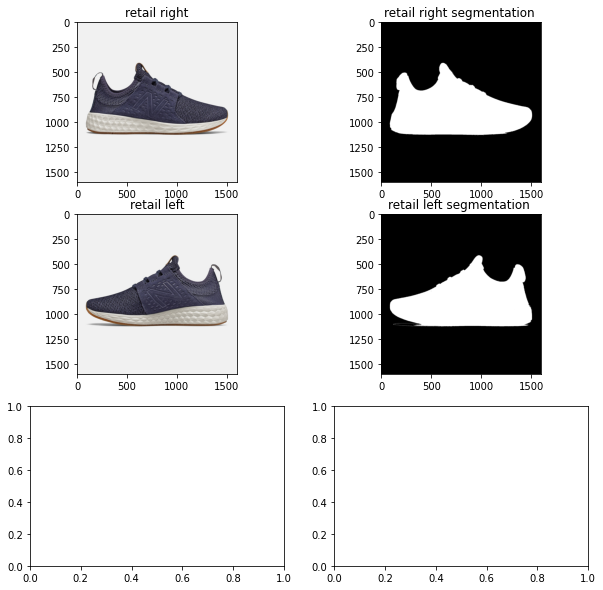

In [66]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

retail_orientations = ['right', 'left']#, 'top'
retail_lst = []

for i, s in enumerate(retail_orientations):
  retail_path = '/content/drive/My Drive/504_project/Stitching/{}.jpg'.format(s)
  retail = plt.imread(retail_path)/255
  ax[i, 0].imshow(retail, cmap="gray")
  ax[i, 0].set_title("retail {}".format(s))

  retail_seg_path = '/content/drive/My Drive/504_project/Stitching/{}_photoshoped_blue.jpg'.format(s)
  retail_seg = plt.imread(retail_seg_path)/255
  retail_seg = retail_seg[:,:,0] != 0
  ax[i, 1].imshow(retail_seg, cmap="gray")
  ax[i, 1].set_title("retail {} segmentation ".format(s))

  retail_lst.append(Photo(retail, retail_seg, name=s))

plt.show()

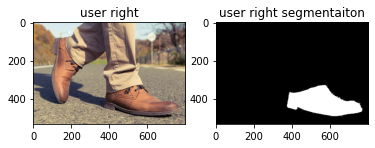

In [67]:
fig, ax = plt.subplots(1, 2)

user_path = '/content/drive/My Drive/504_project/Stitching/user_right_occluded.jpg'
user = plt.imread(user_path)/255
ax[0].imshow(user, cmap="gray")
ax[0].set_title("user right")

user_seg_path = '/content/drive/My Drive/504_project/Stitching/user_right_occluded_blue.jpg'
user_seg = plt.imread(user_seg_path)/255
user_seg = user_seg[:,:,0] != 0
ax[1].imshow(user_seg, cmap="gray")
ax[1].set_title("user right segmentaiton")

plt.show()

user = Photo(user, user_seg)

#**Pad Image**

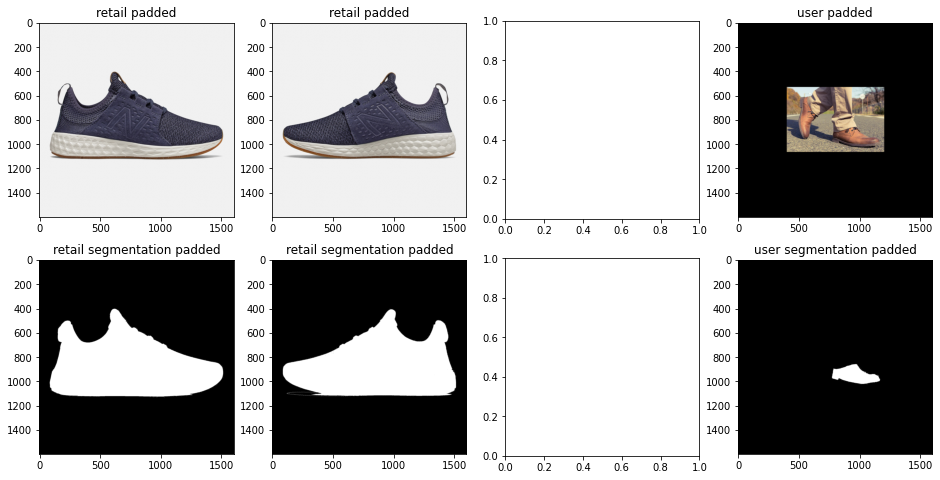

In [68]:
#########################################
#Pad images to make all the same sizes
#cv2.copyMakeBorder Ref: https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
#########################################

#find largest width and height
max_height, max_width = 0,0

for retail in retail_lst:
  max_height = max(max_height, retail.height)
  max_width = max(max_width, retail.width)
max_height = max(max_height, user.height)
max_width = max(max_width, user.width)

#pad retail photos
for retail in retail_lst:
  retail.add_padding(max_height, max_width)
#pad user photo
user.add_padding(max_height, max_width)

#visualize padded images and segmentation maps
fig, ax = plt.subplots(2,4, figsize=(16,8))

for i, retail in enumerate(retail_lst):
  ax[0, i].imshow(retail.padded, cmap='gray')
  ax[0, i].set_title("retail padded")
  ax[1, i].imshow(retail.padded_seg_map, cmap='gray')
  ax[1, i].set_title("retail segmentation padded")

ax[0, -1].imshow(user.padded, cmap='gray')
ax[0, -1].set_title("user padded")
ax[1, -1].imshow(user.padded_seg_map, cmap='gray')
ax[1, -1].set_title("user segmentation padded")

plt.show()

#**Find Largest Eigenvectors**

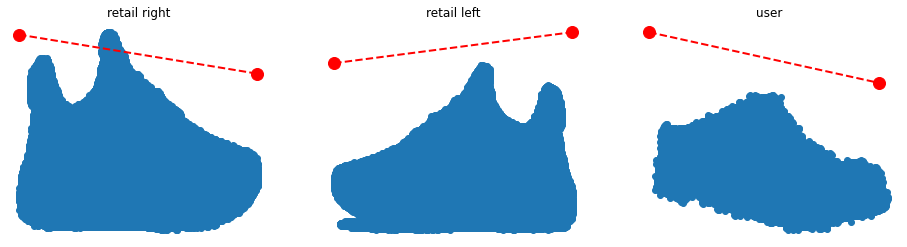

In [69]:
##############################
#visualize largest eigenvector
##############################
fig, ax = plt.subplots(1,3, figsize=(16,4))
for x in ax:
  x.set_axis_off()

rows, cols = user.padded_height, user.padded_width

user_eigvec = user.largest_eigvec()
Y, X = user.padded_seg_map.nonzero()
ax[-1].scatter(X,Y*-1)
ax[-1].plot([user_eigvec[0]*min(X), user_eigvec[0]*max(X)], 
            [(user_eigvec[1]*min(X)+min(Y)-200)*-1, (user_eigvec[1]*max(X)+min(Y)-200)*-1], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax[-1].set_title("user")

for i, retail in enumerate(retail_lst):
  retail_eigvec = retail.largest_eigvec()
  Y, X = retail.padded_seg_map.nonzero()
  ax[i].scatter(X,Y*-1)
  ax[i].plot([retail_eigvec[0]*min(X), retail_eigvec[0]*max(X)],
             [(retail_eigvec[1]*min(X)+min(Y))*-1, (retail_eigvec[1]*max(X)+min(Y))*-1], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12)
  ax[i].set_title("retail {}".format(retail_orientations[i]))

plt.show()  

#**PCA orientation matching**

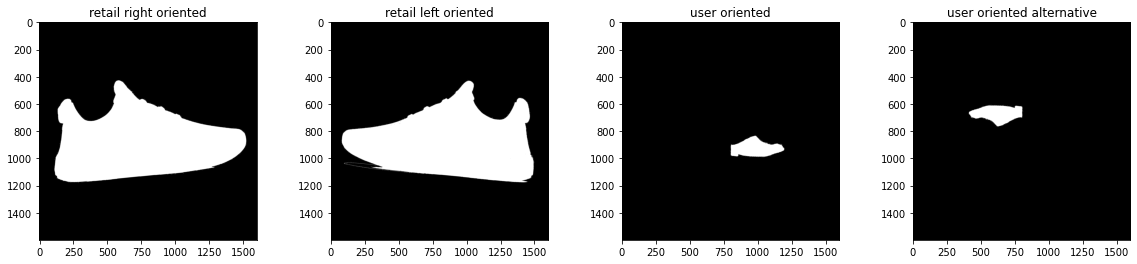

In [70]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

for i, retail in enumerate(retail_lst):
  retail.align_eigvec()
  ax[i].imshow(retail.seg_oriented, cmap="gray")
  ax[i].set_title("retail {} oriented".format(retail_orientations[i]))

for i, alternative in enumerate([False, True]):
  user.align_eigvec(alternative)
  if alternative:
    title = "user oriented alternative"
    ax[-2+i].imshow(user.seg_oriented_alt, cmap="gray")
    ax[-2+i].set_title(title)
  else:
    title = "user oriented"
    ax[-2+i].imshow(user.seg_oriented, cmap="gray")
    ax[-2+i].set_title(title)
  
plt.show()

#**Match Contours**

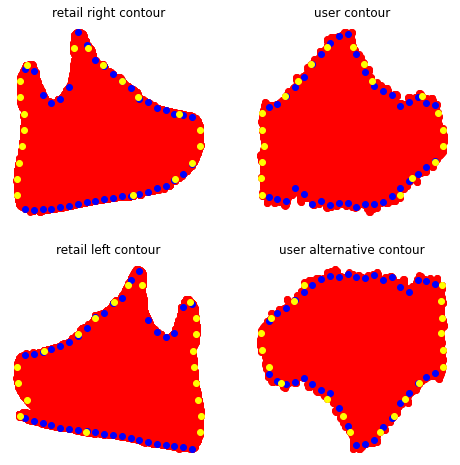

In [77]:
##############################
#visualize contour matching
##############################
fig, ax = plt.subplots(2, 2, figsize=(8,8))

num_slices = 20

for i, retail in enumerate(retail_lst):
  retail_contour_X, retail_contour_Y = retail.contour_slices(num_slices=num_slices)

  Y, X = retail.seg_oriented.nonzero()
  ax[i, 0].set_axis_off()
  ax[i, 0].scatter(X, Y*-1, color='red')
  ax[i, 0].scatter(retail_contour_X[:num_slices*2], retail_contour_Y[:num_slices*2]*-1, color='blue')
  ax[i, 0].scatter(retail_contour_X[-num_slices*2//2:], retail_contour_Y[-num_slices*2//2:]*-1, color='yellow')
  ax[i, 0].set_title("retail {} contour".format(retail_orientations[i]))

for i, alt in enumerate([False, True]):
  Y, X = None, None
  user_contour_X, user_contour_Y = None, None
  title = None
  if alt:
    user_contour_X, user_contour_Y = user.contour_slices(alternative = alt, num_slices=num_slices)
    Y, X = user.seg_oriented_alt.nonzero()
    title = "user alternative contour"
  else:
    user_contour_X, user_contour_Y = user.contour_slices(num_slices=num_slices)
    Y, X = user.seg_oriented.nonzero()
    title = "user contour"
  ax[i, 1].set_axis_off()
  ax[i, 1].scatter(X, Y*-1, color='red')
  ax[i, 1].scatter(user_contour_X[:num_slices*2], user_contour_Y[:num_slices*2]*-1, color='blue')
  ax[i, 1].scatter(user_contour_X[-num_slices*2//2:], user_contour_Y[-num_slices*2//2:]*-1, color='yellow')
  ax[i, 1].set_title(title)

plt.show()

In [72]:
######################################################################
#Pick best matching by calculating homography transform and least squares error
######################################################################

min_cost = math.inf
max_inliers = 0
min_homography_tuple = () #retail, alt(True/False), homography_m

for retail in retail_lst:
  retail_contour_X, retail_contour_Y = retail.X, retail.Y
  src = np.vstack((retail_contour_X, retail_contour_Y)).T
  src_3D = np.vstack((retail_contour_X, retail_contour_Y, np.ones(len(retail_contour_X))))
  for alt in [False, True]:
    user_contour_X, user_contour_Y = None, None
    if alt:
      user_contour_X, user_contour_Y = user.X_alt, user.Y_alt
    else:
      user_contour_X, user_contour_Y = user.X, user.Y

    #find homography transformation matrix
    dst = np.vstack((user_contour_X, user_contour_Y)).T
    homography_m, inliers = cv2.findHomography(src, dst)

    #calculate cost = sum(||Hx-y||^2)
    #cost function potentially needs to take into account number of inliners
    mapped = np.matmul(homography_m, src_3D)
    mapped[0, :] = mapped[0, :] / mapped[2, :]
    mapped[1, :] = mapped[1, :] / mapped[2, :]
    dst = dst.T
    cost = np.sum((mapped[:2, :] - dst)**2)
    num_inliers = np.count_nonzero(inliers)
    print(cost, num_inliers)

    if cost < min_cost and max_inliers <= num_inliers:
      min_homography_tuple = (retail, alt, homography_m)
      min_cost = cost
      max_inliers = num_inliers


30816.339639846046 60
220201.22909050182 60
122265.86714477558 60
170398.9511926289 60


In [73]:
######################################################################
#Pick best machting by calculating affine (similarity) transform and least squares error
######################################################################

min_cost = math.inf
max_inliers = 0
min_affine_tuple = () #retail, alt(True/False), affine_m

for retail in retail_lst:
  retail_contour_X, retail_contour_Y = retail.X, retail.Y
  src = np.vstack((retail_contour_X, retail_contour_Y)).T
  src_3D = np.vstack((retail_contour_X, retail_contour_Y, np.ones(len(retail_contour_X))))
  for alt in [False, True]:
    user_contour_X, user_contour_Y = None, None
    if alt:
      user_contour_X, user_contour_Y = user.X_alt, user.Y_alt
    else:
      user_contour_X, user_contour_Y = user.X, user.Y

    #find affine transformation matrix
    dst = np.vstack((user_contour_X, user_contour_Y)).T
    affine_m, inliers = cv2.estimateAffinePartial2D(src, dst)

    #calculate cost = sum(||Hx-y||^2)
    #cost function potentially needs to take into account number of inliners
    mapped = np.matmul(affine_m, src_3D)
    dst = dst.T
    cost = np.sum((mapped - dst)**2)
    num_inliers = np.count_nonzero(inliers)
    print(cost, num_inliers)
    
    if cost < min_cost and max_inliers <= num_inliers:
      min_affine_tuple = (retail, alt, affine_m)
      min_cost = cost
      max_inliers = num_inliers


55625.360042352746 12
396938.08066942496 8
164774.00992976804 11
298764.50663925894 7


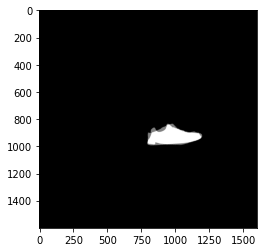

In [74]:
######################################
#Visualize homography transform
######################################
retail, alt, homography_m = min_homography_tuple

retail.homography_transform(homography_m)

overlay = copy.deepcopy(retail.seg_transformed)
if alt:
  overlay = overlay/2 + user.seg_oriented_alt/2
else:
  overlay = overlay/2 + user.seg_oriented/2
plt.imshow(overlay, cmap='gray')

#**Stitching**

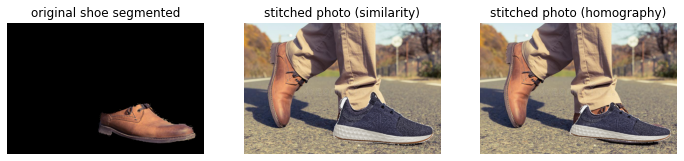

In [75]:
retail, alt, homography_m = min_homography_tuple
homography_final, _ = user.stitch_n_crop(retail, homography_m, is_homography=True, alternative=alt)
homography_final_filtered, _ = user.stitch_n_crop(retail, homography_m, is_homography=True, alternative=alt, filter=True)

retail, alt, affine_m = min_affine_tuple
retail.affine_transform(affine_m)
affine_final, _ = user.stitch_n_crop(retail, affine_m, alternative=alt)
affine_final_filtered, _ = user.stitch_n_crop(retail, affine_m, alternative=alt, filter=True)

#visualize final stitching
fig, ax = plt.subplots(1,3, figsize=(12, 12))
for x in ax:
  x.set_axis_off()

tmp = copy.deepcopy(user.original)
tmp[user.seg_map == 0] = 0
ax[0].imshow(tmp)
ax[0].set_title("original shoe segmented")
ax[1].imshow(affine_final)
ax[1].set_title("stitched photo (similarity)")
ax[2].imshow(homography_final)
ax[2].set_title("stitched photo (homography)")

"""
ax[1, 0].imshow(affine_final_filtered)
ax[1, 0].set_title("stitched photo (affine, filtered)")
ax[1, 1].imshow(homography_final_filtered)
ax[1, 1].set_title("stitched photo (homography, filtered)")
"""

plt.show()


#**Picking the Best Option (Similarity/ Homography, Filter Y/N)**

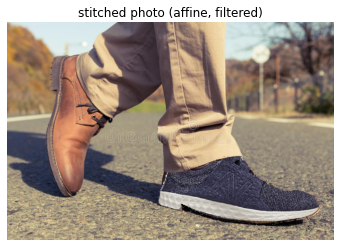

In [76]:
retail_h, alt_h, homography_m = min_homography_tuple
homography_final, homography_seg = user.stitch_n_crop(retail_h, homography_m, is_homography=True, alternative=alt)

retail_a, alt_a, affine_m = min_affine_tuple
affine_final, affine_seg = user.stitch_n_crop(retail_a, affine_m, alternative=alt)

#pick the option where retail segmentaion covers more of user segmentation
better_option = ""
final = None
count = 0
if np.count_nonzero(user.seg_map[homography_seg]) < np.count_nonzero(user.seg_map[affine_seg]):
  better_option = "affine"
  final = affine_final
  count = np.count_nonzero(user.seg_map[affine_seg])
else:
  better_option = "homography"
  final = homography_final
  count = np.count_nonzero(user.seg_map[homography_seg])

#decide to filter by user segmentation if retail overflows by a certain threshold
#i.e. user segmentation the retail segmentation less than a certain threshold
filtered = ""
threshold = 0.8
if better_option == "affine" and count/ np.count_nonzero(affine_seg) < threshold:
  final, _ = user.stitch_n_crop(retail, affine_m, alternative=alt, filter=True)
  filtered = ", filtered"
  #print(count/ np.count_nonzero(affine_seg))
elif better_option == "homography" and count/ np.count_nonzero(homography_seg) < threshold:
  final, _ = user.stitch_n_crop(retail_h, homography_m, is_homography=True, alternative=alt, filter=True)
  filtered = ", filtered"
  #print(count/ np.count_nonzero(homography_seg))

plt.imshow(final)
plt.title("stitched photo ({}{})".format(better_option, filtered))
_ = plt.axis('off')